# PDE- Constrained Shape Optimization in NGSolve
# Laminar stationary Stokes flow around an obstacle
## Computational Mathematics Seminary - TU Vienna
## Authors: Paul Genest & Camilo Tello Fachin
## Supervisor: Dr. Kevin Sturm


Import relevant libraries

In [76]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

Setup Geometry with 2 different mesh density regions
- $\tt{h_{fine}}$ is the parameter for the mesh region adjacent to the Cylinder Boundary $\Gamma$
- $\tt{h_{coarse}}$ for the region adjacent to the outer domain boundary $\Gamma_{\infty}$

In [77]:
geo = SplineGeometry()
h_coarse = 1.5
h_fine = 1.5
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "in"), leftdomain=1, rightdomain=0, maxh=h_coarse) 
geo.AddCircle(c=(0, 0), r=0.7, leftdomain=2, rightdomain=1, bc="outer_cylinder", maxh=h_fine) 
geo.AddCircle(c=(0, 0), r=0.5, leftdomain=0, rightdomain=2, bc="cyl", maxh=h_fine) 
#geo.SetDomainMaxH(2, 0.08)
mesh = Mesh(geo.GenerateMesh(maxh=h_coarse))
mesh.Curve(1);

geo_1 = SplineGeometry()
geo_1.AddRectangle((0,0),(1,1))
mesh_1 = Mesh(geo_1.GenerateMesh())
scene1 = Draw(mesh)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2204', 'mesh_dim': 2, 'order2d': 1, 'order3d':…

Setup Vector spaces for Taylor Hood Elements

In [78]:
# Order of spaces for Taylor-Hood Elements
k = 2
# H1 vs VectorH1 -> vector field?!
V = H1(mesh,order=k, dirichlet="top|bot|cyl|in|out")
Q = H1(mesh,order=k-1)
FES = FESpace([V,V,Q]) # [V,Q] (without VectorH1)

Setup bilinear form corresponding to the weak formulation of the linear stationary Stokes PDE: 

Find $u \in [H^1_0(\Omega)]^d$ and $p \in L^2(\Omega)$ such that:
\begin{align*}
    \int_{\Omega} \nabla u : \nabla v \, dx + \int_{\Omega} \mathrm{div}(v)p \, dx + \int_{\Omega} \mathrm{div}(u)q \, dx = \, 0 \quad \forall (v,q)
    \in  [H^1_0(\Omega)]^d \times L^2(\Omega)
\end{align*}

In [79]:
ux,uy,p = FES.TrialFunction()
vx,vy,q = FES.TestFunction()

# stokes equation
def Equation(ux,uy,p,vx,vy,q):
    div_u = grad(ux)[0]+grad(uy)[1] # custom div
    div_v = grad(vx)[0]+grad(vy)[1]
    return (grad(ux)*grad(vx)+grad(uy)*grad(vy) + div_u*q + div_v*p)* dx

a = BilinearForm(FES)
a += Equation(ux,uy,p,vx,vy,q)
a.Assemble()

Setup the Boundary conditions by overwriting the solution variable $\tt{gfu}$ at the corresponding entries:

\begin{aligned}
    \mathbf{u} &=0& \, &\text{on } \Gamma,& \\
    \mathbf{u} &=\mathbf{u}_{\infty}& \, &\text{on } \Gamma_{\infty},& \\
\end{aligned}

In the beginning, the mesh is visible with the gridfunction $\tt{gfu}$ plotted with only the boundary conditions applied. During the iterations, the perturbed mesh with the solution to the stokes flow on the perturbed domain is plotted.

In [80]:
gfu = GridFunction(FES)
uinf = 0.0005
uin = CoefficientFunction((uinf))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("in|top|bot|out"))

x_velocity = CoefficientFunction(gfu.components[0])
scene_state = Draw(x_velocity, mesh, "vel")

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2204', 'mesh_dim': 2, 'order2d': 2, 'order3d':…

Solve stokes by inverting the assembled matrix $\mathbf{A}$

In [81]:
def solveStokes():
    res = gfu.vec.CreateVector()
    res.data = -a.mat * gfu.vec
    inv = a.mat.Inverse(FES.FreeDofs())
    gfu.vec.data += inv * res
    scene_state.Redraw()
solveStokes()

Create a Function that returns a scalar representative quantitiy for the "dissipated energy" 
over the domain $\Omega$ :

\begin{align*}
    J(\Omega ) = \frac{1}{2} \int_\Omega Du : Du \ \mathrm{dx}
\end{align*}

In [82]:
def calc_drag(gfu):
    ux = gfu.components[0]
    uy = gfu.components[1]
    return 0.5*(grad(ux)*grad(ux)+grad(uy)*grad(uy)).Compile()*dx

Create a function that returns a scalar quantity corresponding to the quadratically penalized term
in the augmented lagrangian for the constant volume side constraint. If the perturbed domain yields an obstacle that is of same volume, the function returns 0. (otherwise a volume deviation of the obstacles is quadratically penalized)

\begin{align*}
    \mathrm{vol}(\Omega) &= \int_{\Omega} 1 \ \mathrm{dx} \in \mathbb{R} \\
    \mathcal{L}_{\mathrm{vol}} &= \alpha \ \Big( \mathrm{vol}( \mathbf{T}_{t}(\Omega) )-\mathrm{vol}(\Omega_0) \Big) ^2
\end{align*}

In [83]:
alpha = 1e-4
surf_t = CoefficientFunction(1)
surf_0 = Integrate(surf_t,mesh)

def calc_surf_change():
    return alpha*(surf_t*dx-surf_0)**2

In this Cell the barycenter of the unperturbed domain $\Omega$ is calculated. This is used for the barycenter term in the augmented Lagrangian later on. For arbitrary geometry setups, the barycenter of the obstacle should be used, since the geometry at hand is symmetrical, the barycenter of the domain is equivalent :

\begin{align*}
    \vec{r}_{\mathrm{bc}} &=
    \frac{1}{\mathrm{vol}(\Omega)}\int_{\Omega} \mathbf{x} \ \mathrm{d} \mathbf{x} \in \mathbb{R}^d \\
\end{align*}

The barycenter sideconstraint is vectorial. Since the Lagrangian only treats scalar quantities
it is decomposed into its compontents:

\begin{align*}
    \vec{r}_{\mathrm{bc}} \cdot \vec{e}_x &=
    \frac{1}{\mathrm{vol}(\Omega)}\int_{\Omega} x \ \mathrm{d}x \in \mathbb{R} \\
    \vec{r}_{\mathrm{bc}} \cdot \vec{e}_y &=
    \frac{1}{\mathrm{vol}(\Omega)}\int_{\Omega} y \ \mathrm{d}x \in \mathbb{R} \\
\end{align*}

In [84]:
bc_tx = CoefficientFunction(x)
bc_ty = CoefficientFunction(y)
bc_0x = 1/surf_0*Integrate(bc_tx,mesh)
bc_0y = 1/surf_0*Integrate(bc_ty,mesh)

# creation of Shapediff Space + pertubation Function
function that will perturb our mesh

In [85]:
# Test and trial functions for shape derivate
VEC = H1(mesh, order=2, dim=2, dirichlet="top|bot|in|out")
PHI, X = VEC.TnT()
# gfset denotes the deformation of the original domain and will be updated during the shape optimization
gfset = GridFunction(VEC)
gfset.Set((0,0))
mesh.SetDeformation(gfset)
SetVisualization (deformation=True)

# deformation calculation
gfX = GridFunction(VEC)

# Shape Optimization
Since the existstence of the Shape Derivative is shown in the seminary paper, one can use an augmented Lagrangian to find a minimum of the problem by iteratively finding minimizers
of the quadratically penalized Lagrangian which are approximate minimizers to the original minimization problem:


\begin{align*}
\frac{1}{2} \int_\Omega Du : Du dx + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2 
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s)) - \mathrm{Bc}_j(\Omega_0)\Big)^2
\end{align*}

hallo hallo hallo

\begin{align*}
\min_{h,u,s}  & \int_{\Omega(s)} \sum_{i,j=1}^2 \left( \frac{\partial u_i}{\partial x_j}\right)^2~\mathrm{d} x \\
&+ \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2 \\
&+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s))-\mathrm{Bc}_j(\Omega_0)\Big)^2,\\
\end{align*}

In [86]:
ux = gfu.components[0]
uy = gfu.components[1]
p = gfu.components[2]

vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))

Lagrangian = Equation(ux,uy,p,ux,uy,p) + calc_drag(gfu)  

In [87]:
dJOmega = LinearForm(VEC)
dJOmega += Lagrangian.DiffShape(X)

# volume side constraint
vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))
alpha0 = 1e-4
alpha = Parameter(alpha0)
#dJOmega += ((2*alpha*((vol-surf_0))*vol)*dx).DiffShape(X).Compile().DiffShape(X) # (definedon="mesh_1")
dJOmega += 2*alpha*(vol-surf_0)*div(X)*dx

# barycenter x sideconstraint
beta0 = 1e-3
beta = Parameter(beta0)
bc_x = Parameter(1)
bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
dJOmega += 2*beta*(bc_x-bc_0x)*((1/vol**2)*div(X)*x+(1/vol)*div(X)*x*sum(gfset.vecs[0].data)[0])*dx

# barycenter y sideconstraint
bc_y = Parameter(1)
bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
dJOmega += 2*beta*(bc_y-bc_0y)*((1/vol**2)*div(X)*y+(1/vol)*div(X)*y*sum(gfset.vecs[0].data)[1])*dx


b = BilinearForm(VEC)
#b += (InnerProduct(grad(X),grad(PHI))).Compile() *dx + (InnerProduct(X,PHI)).Compile()*dx
b += (InnerProduct(grad(X),grad(PHI)+grad(PHI).trans)).Compile() *dx + (InnerProduct(X,PHI)).Compile()*dx

#Cauchy-Riemann Penalisation
gamma0 = 25
gamma = Parameter(gamma0)
Gamma = 50
b += Gamma*(PHI.Deriv()[0,0] - PHI.Deriv()[1,1])*(X.Deriv()[0,0] - X.Deriv()[1,1])*dx
b += Gamma*(PHI.Deriv()[1,0] - PHI.Deriv()[0,1])*(X.Deriv()[1,0] - X.Deriv()[0,1])*dx

In [88]:
def updateParams(v=False):
    vol.Set(Integrate(surf_t,mesh))
    bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
    bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
    if(v):
        print(vol.Get(), bc_x.Get(), bc_y.Get())
updateParams()

def increaseParams(k=2,v=False):
    alpha.Set(alpha.Get()*k)
    beta.Set(beta.Get()*k)
    gamma.Set(gamma.Get()*k)
    if(v):
        print("alpha: ", alpha.Get(), ", beta: ", beta.Get(), ", gamma: ", gamma.Get())

In [89]:
def SolveDeformationEquation():
    rhs = gfX.vec.CreateVector()
    rhs.data = dJOmega.vec - b.mat * gfX.vec
    update = gfX.vec.CreateVector()
    update.data = b.mat.Inverse(VEC.FreeDofs()) * rhs
    gfX.vec.data += update

### Visualisation of the Shape Derivative by showing two quantities:
 
- The Perturbed Domain

\begin{align*}
  \Omega + tX
\end{align*}

- The Deformation Field Magnitude on the Perturbed Domain
\begin{align*}
  || X ||_{L^2( \Omega_{\mathrm{n}} )}
\end{align*}

In [90]:
scene = Draw(gfX)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2204', 'mesh_dim': 2, 'order2d': 2, 'order3d':…

## Iterations - Gradient Descent Method

In [91]:
gfset.Set((0,0))
mesh.SetDeformation(gfset)
scene.Redraw()

updateParams()
alpha0 = 1e-4
beta0 = 1e-0
gamma0 = 1e2
alpha.Set(alpha0)
beta.Set(beta0)
gamma.Set(gamma0)

a.Assemble()
solveStokes()

data = [[] for x in range(7)]

iter_max = 100
Jold = Integrate(calc_drag(gfu), mesh)

# try parts of loop
mesh.SetDeformation(gfset)
scene.Redraw()

c = 0

# input("Press enter to start optimization")
for i in range(0,iter_max):
    mesh.SetDeformation(gfset)
    scene.Redraw()
    scene_state.Redraw()
    
    if i%50 == 0:
        print('drag at iteration', i, ': ', Jold)
        
    titles = ["Energy Dissipation","Volume","bc_x","bc_y","scale","gfxnorm","gfxbndnorm"] # collecting data
    data[0].append(Integrate(calc_drag(gfu),mesh))
    data[1].append(vol.Get())
    data[2].append(bc_x.Get())
    data[3].append(bc_y.Get())
    
    a.Assemble()
    solveStokes()
    
    b.Assemble()
    dJOmega.Assemble()
    SolveDeformationEquation()
    updateParams()
    
    Jnew = Integrate(calc_drag(gfu), mesh)
    mesh.UnsetDeformation()
    
    gfxnorm = Norm(gfX.vec)
    gfxbndnorm = Integrate(sqrt(gfX**2),mesh,BND)
    data[6].append(gfxbndnorm)
    #scale = 0.1 / Norm(gfX.vec)
    scale = 0.01 / gfxnorm
    data[4].append(scale)
    jdiff = abs(Jnew-Jold)
    data[5].append(gfxnorm)
    
    
    c += 1
    #if(gfxnorm < 1e-5):
    if(gfxbndnorm < 1e-7 and c > 50):
        if alpha.Get() < 100:
            increaseParams(5,True)
            c = 0
        else:
            print("alpha too big")
            break
            
    gfsetOld = gfset
    gfset.vec.data -= scale * gfX.vec
    Jold = Jnew

    Redraw(blocking=True)

drag at iteration 0 :  2.679001976562603e-06
drag at iteration 50 :  2.4606127962223907e-06


## Function for evaluating the Element Quality Distribution on the domain $\Omega_{\mathrm{n}}$

In [92]:
Element_Iterator = mesh.Elements()
Element_Quality_Data = np.empty(Element_Iterator.stop)
deformation_vector = np.asarray(gfset.vec)

# Element Quality ratio eta with sidelengths a,b,c of element K
def eta_K(abc):
    A, B, C = abc[0,:], abc[1,:], abc[2,:]
    a, b, c = np.linalg.norm(A-C), np.linalg.norm(A-B), np.linalg.norm(B-C)
    s = 1/2*(a+b+c) #half the circumference of element
    A = np.sqrt(s*(s-a)*(s-b)*(s-c)) #Area calculation with Heron Theorem
    r = 2*A / (a+b+c) # radius of inscribed circle
    R = (a*b*c) / (4*A) # radius of circumscribed circle
    eta = R / (2*r) 
    return eta

for elmnt in mesh.Elements():
    el = NodeId(ELEMENT,elmnt.nr)
    meshel = mesh[el]
    abc = np.empty([3,2])
    counter = 0

    for vert in elmnt.vertices:
        ve = NodeId(VERTEX, vert.nr)
        meshvert = mesh[ve]
        abc[counter] = np.asarray(meshvert.point) + deformation_vector[vert.nr]
        counter += 1

    counter = 0
    Element_Quality_Data[elmnt.nr] = eta_K(abc)

## Only Plot Settigns & Plots from here on:

In [93]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 3

plt.rc('text', usetex=True)
plt.rcParams['text.usetex']=True

plt.rc('font', family='sans-serif', weight='bold')

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<Figure size 4000x1500 with 0 Axes>

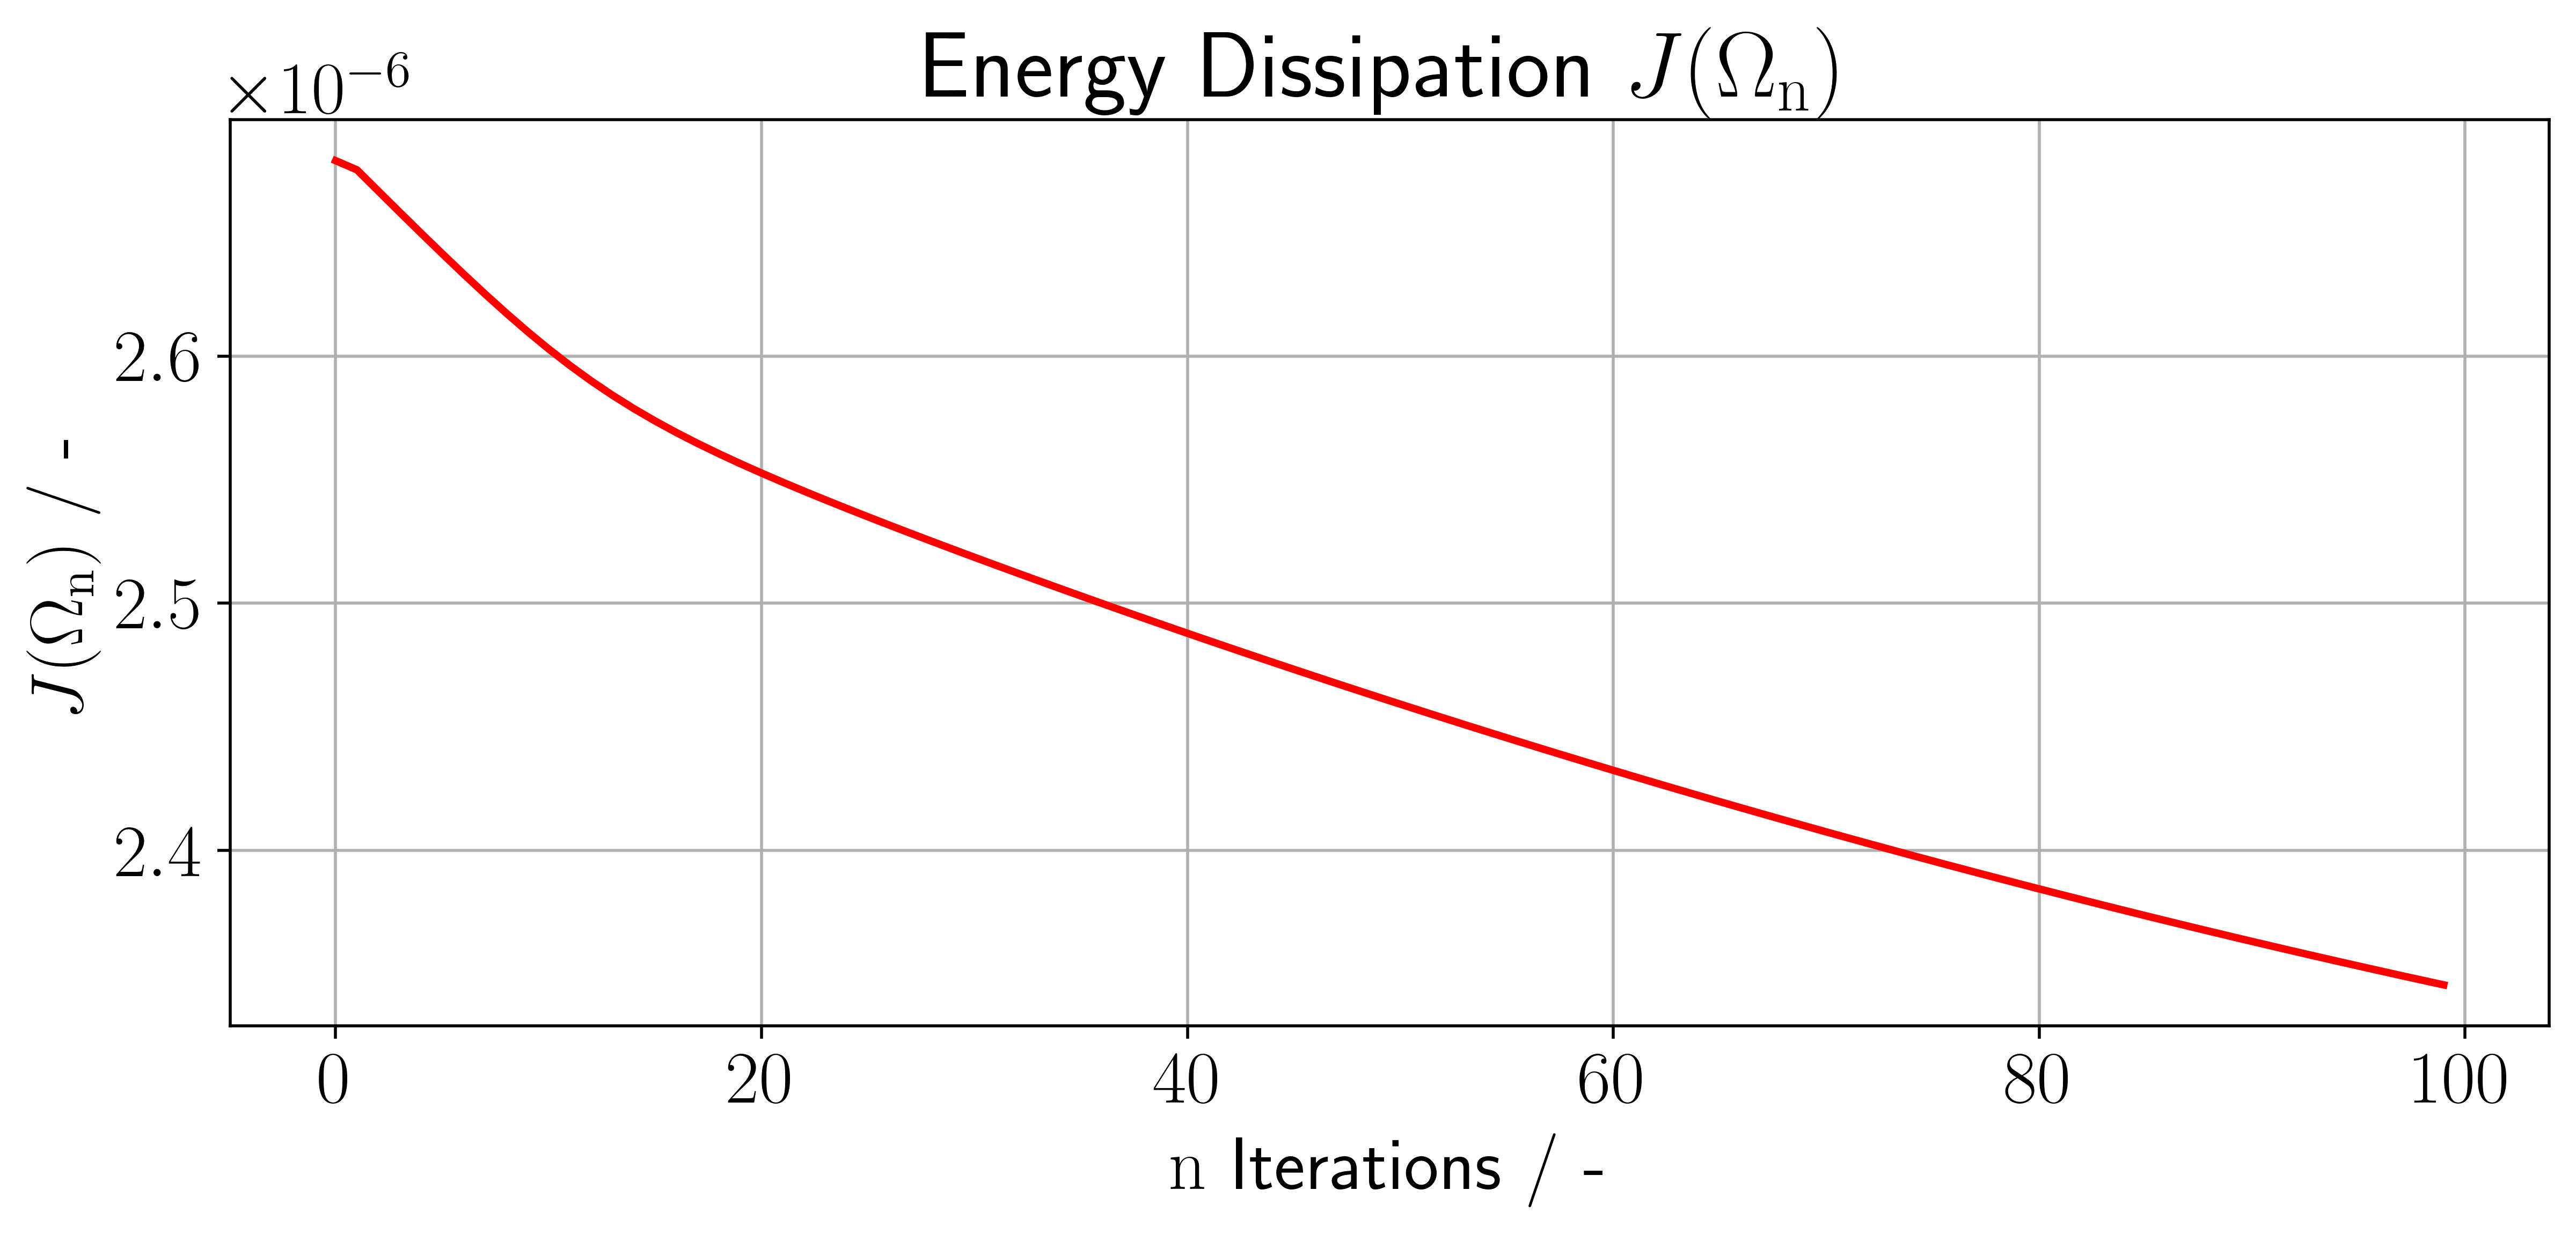

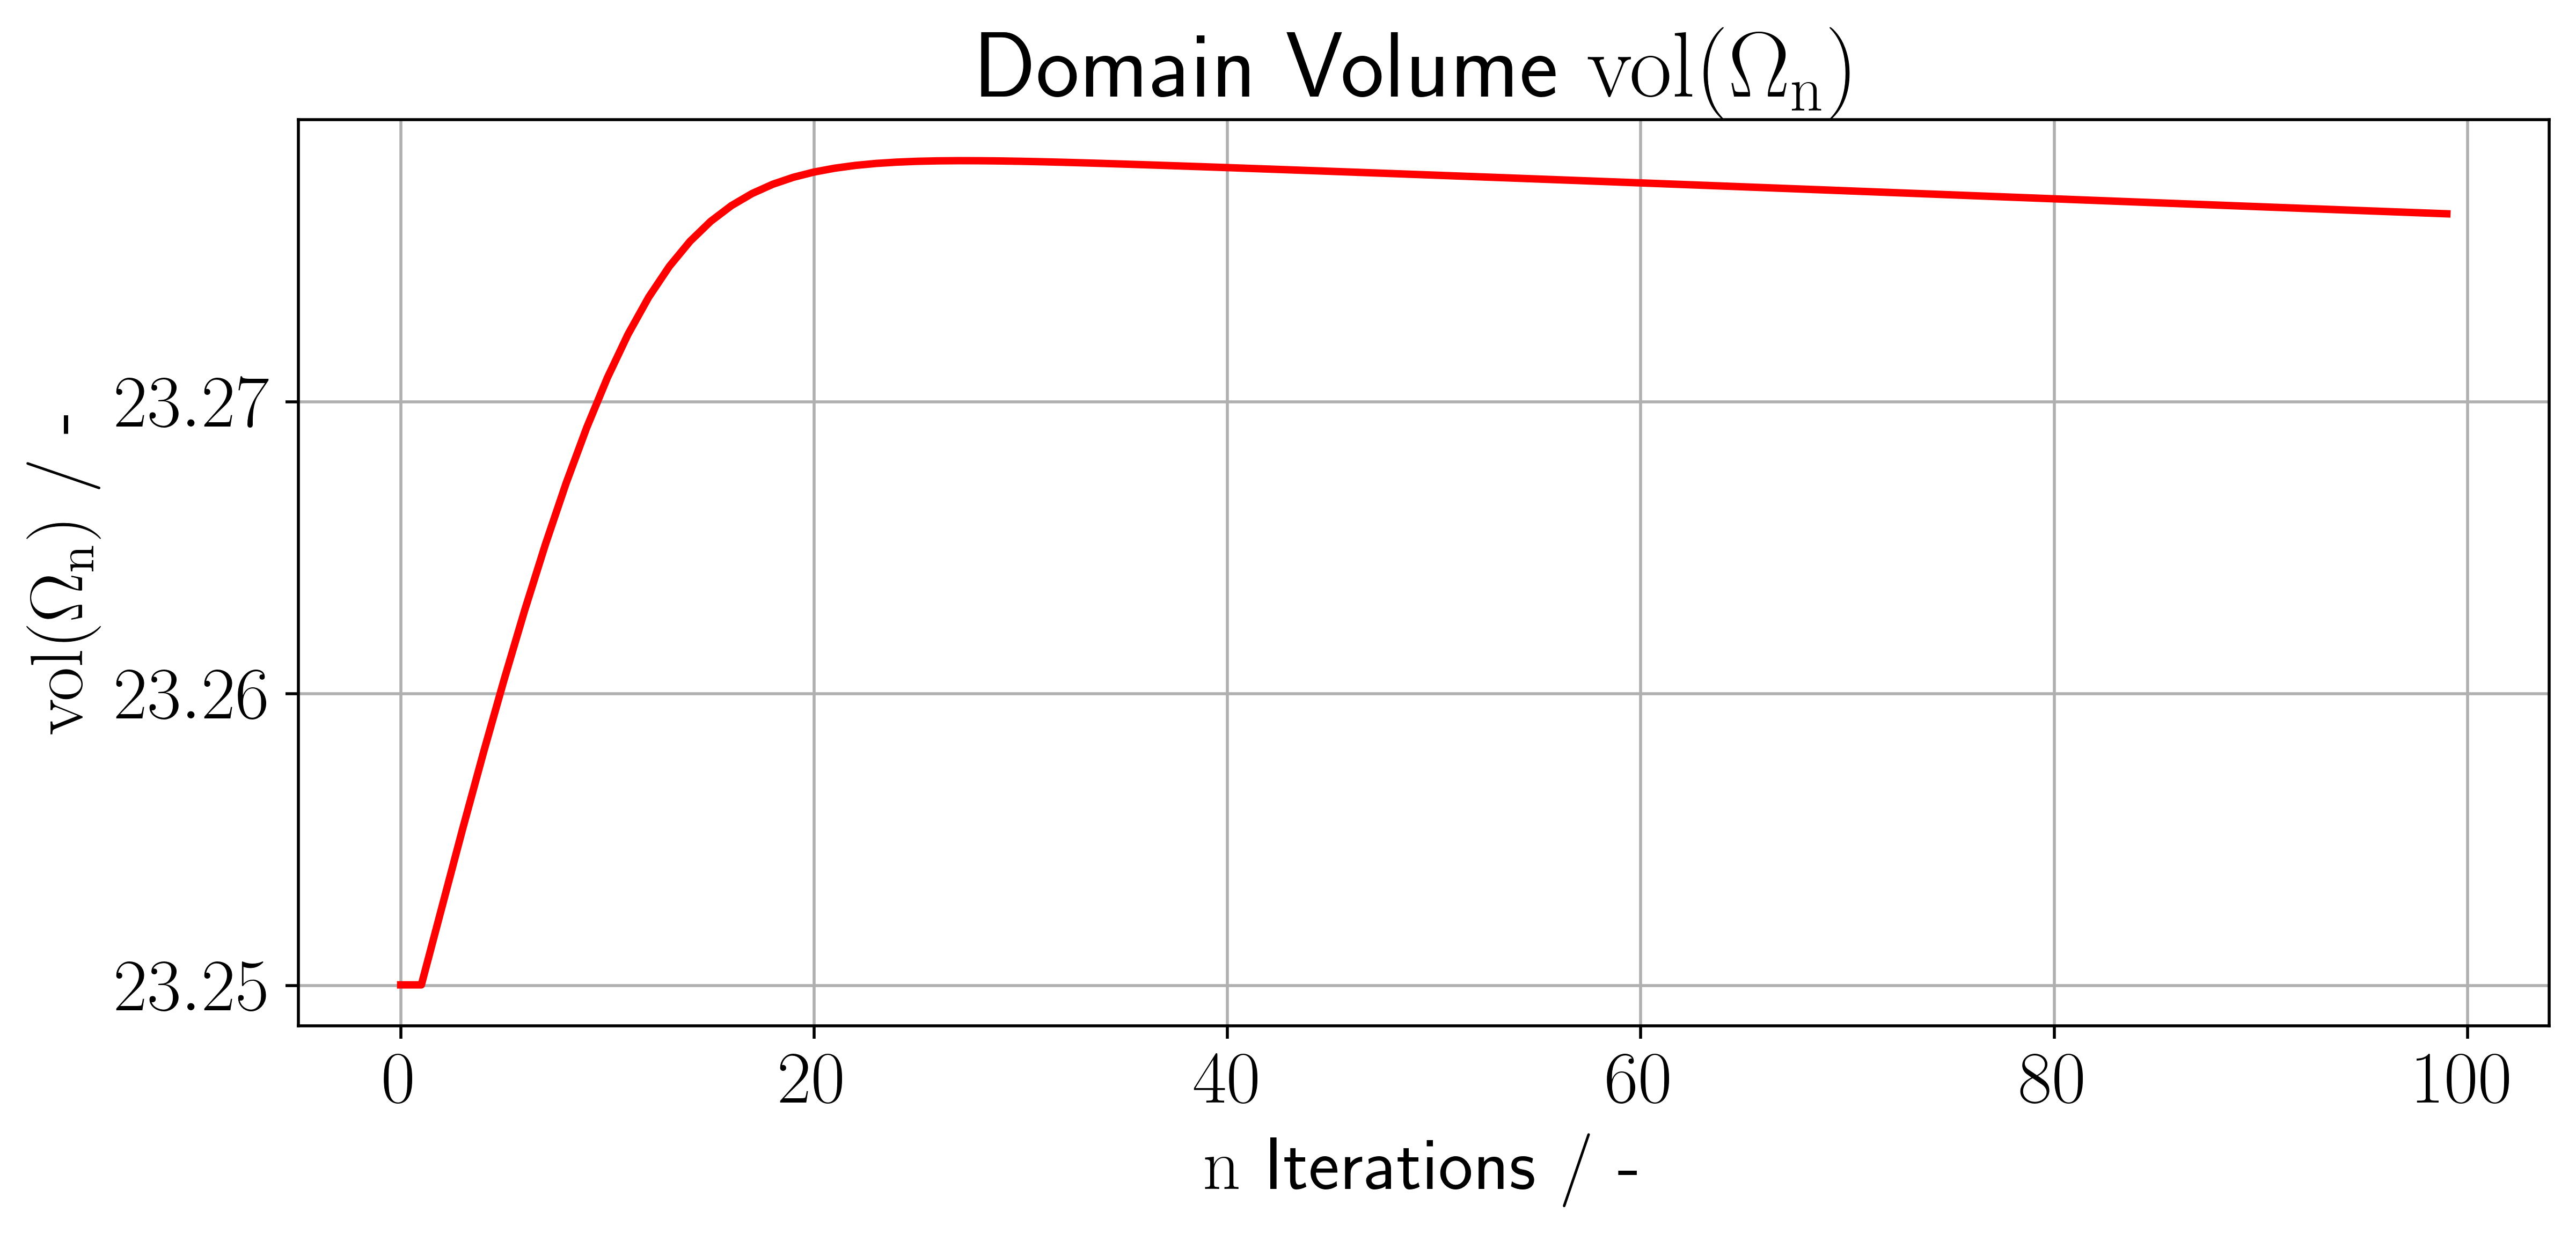

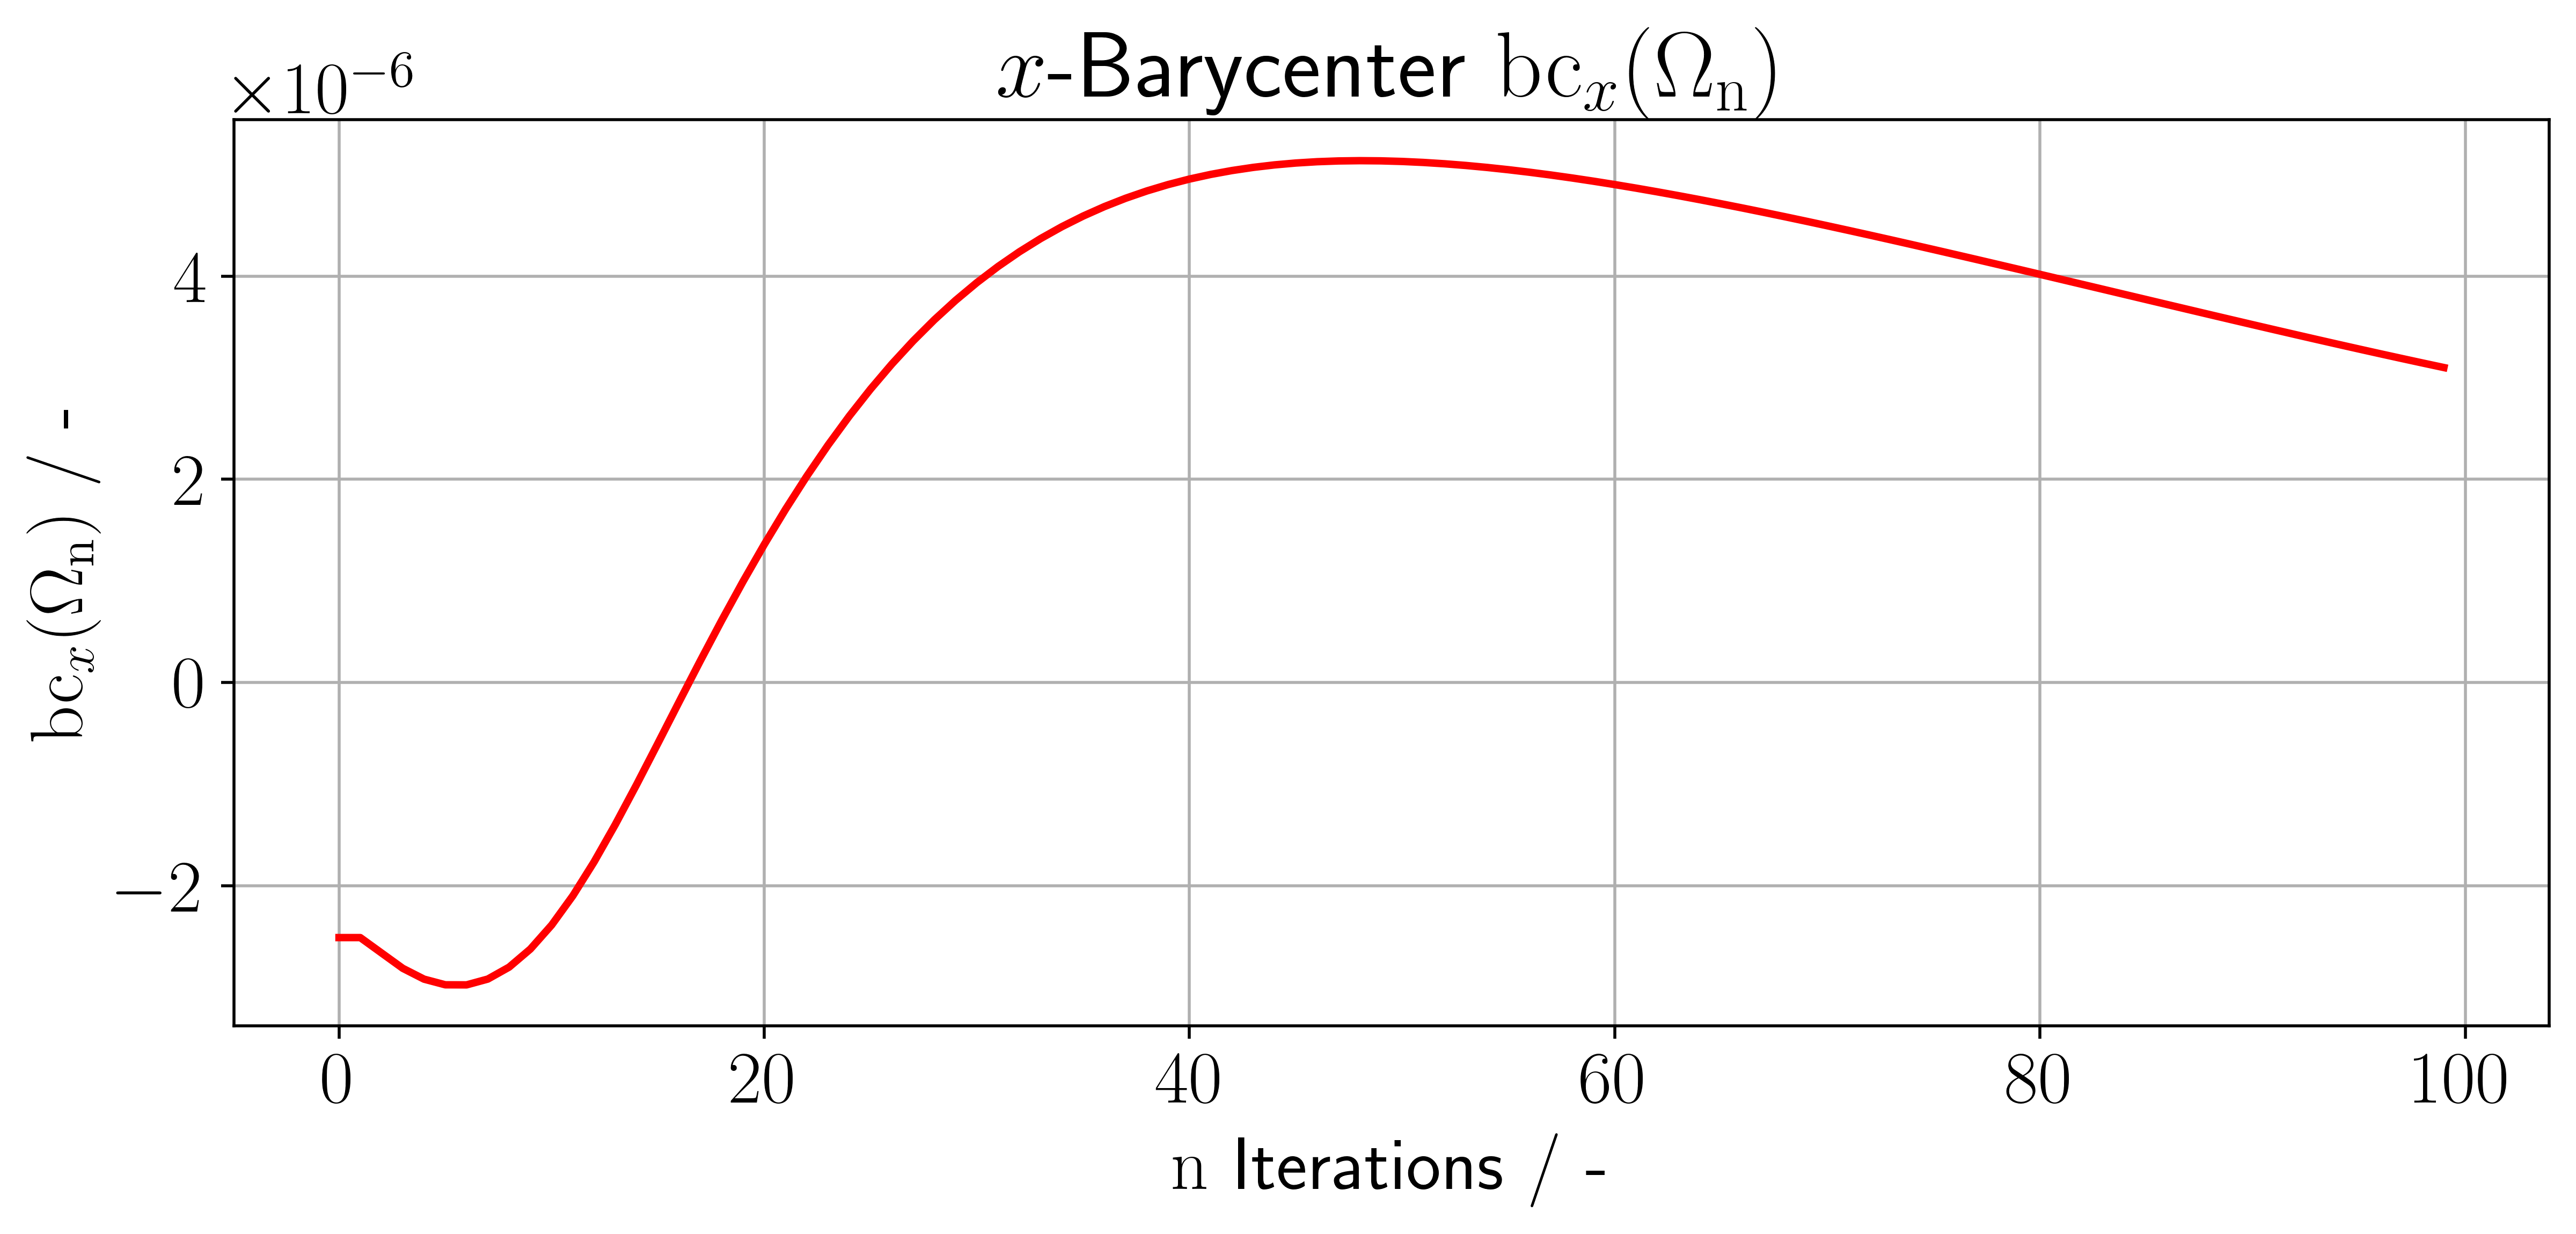

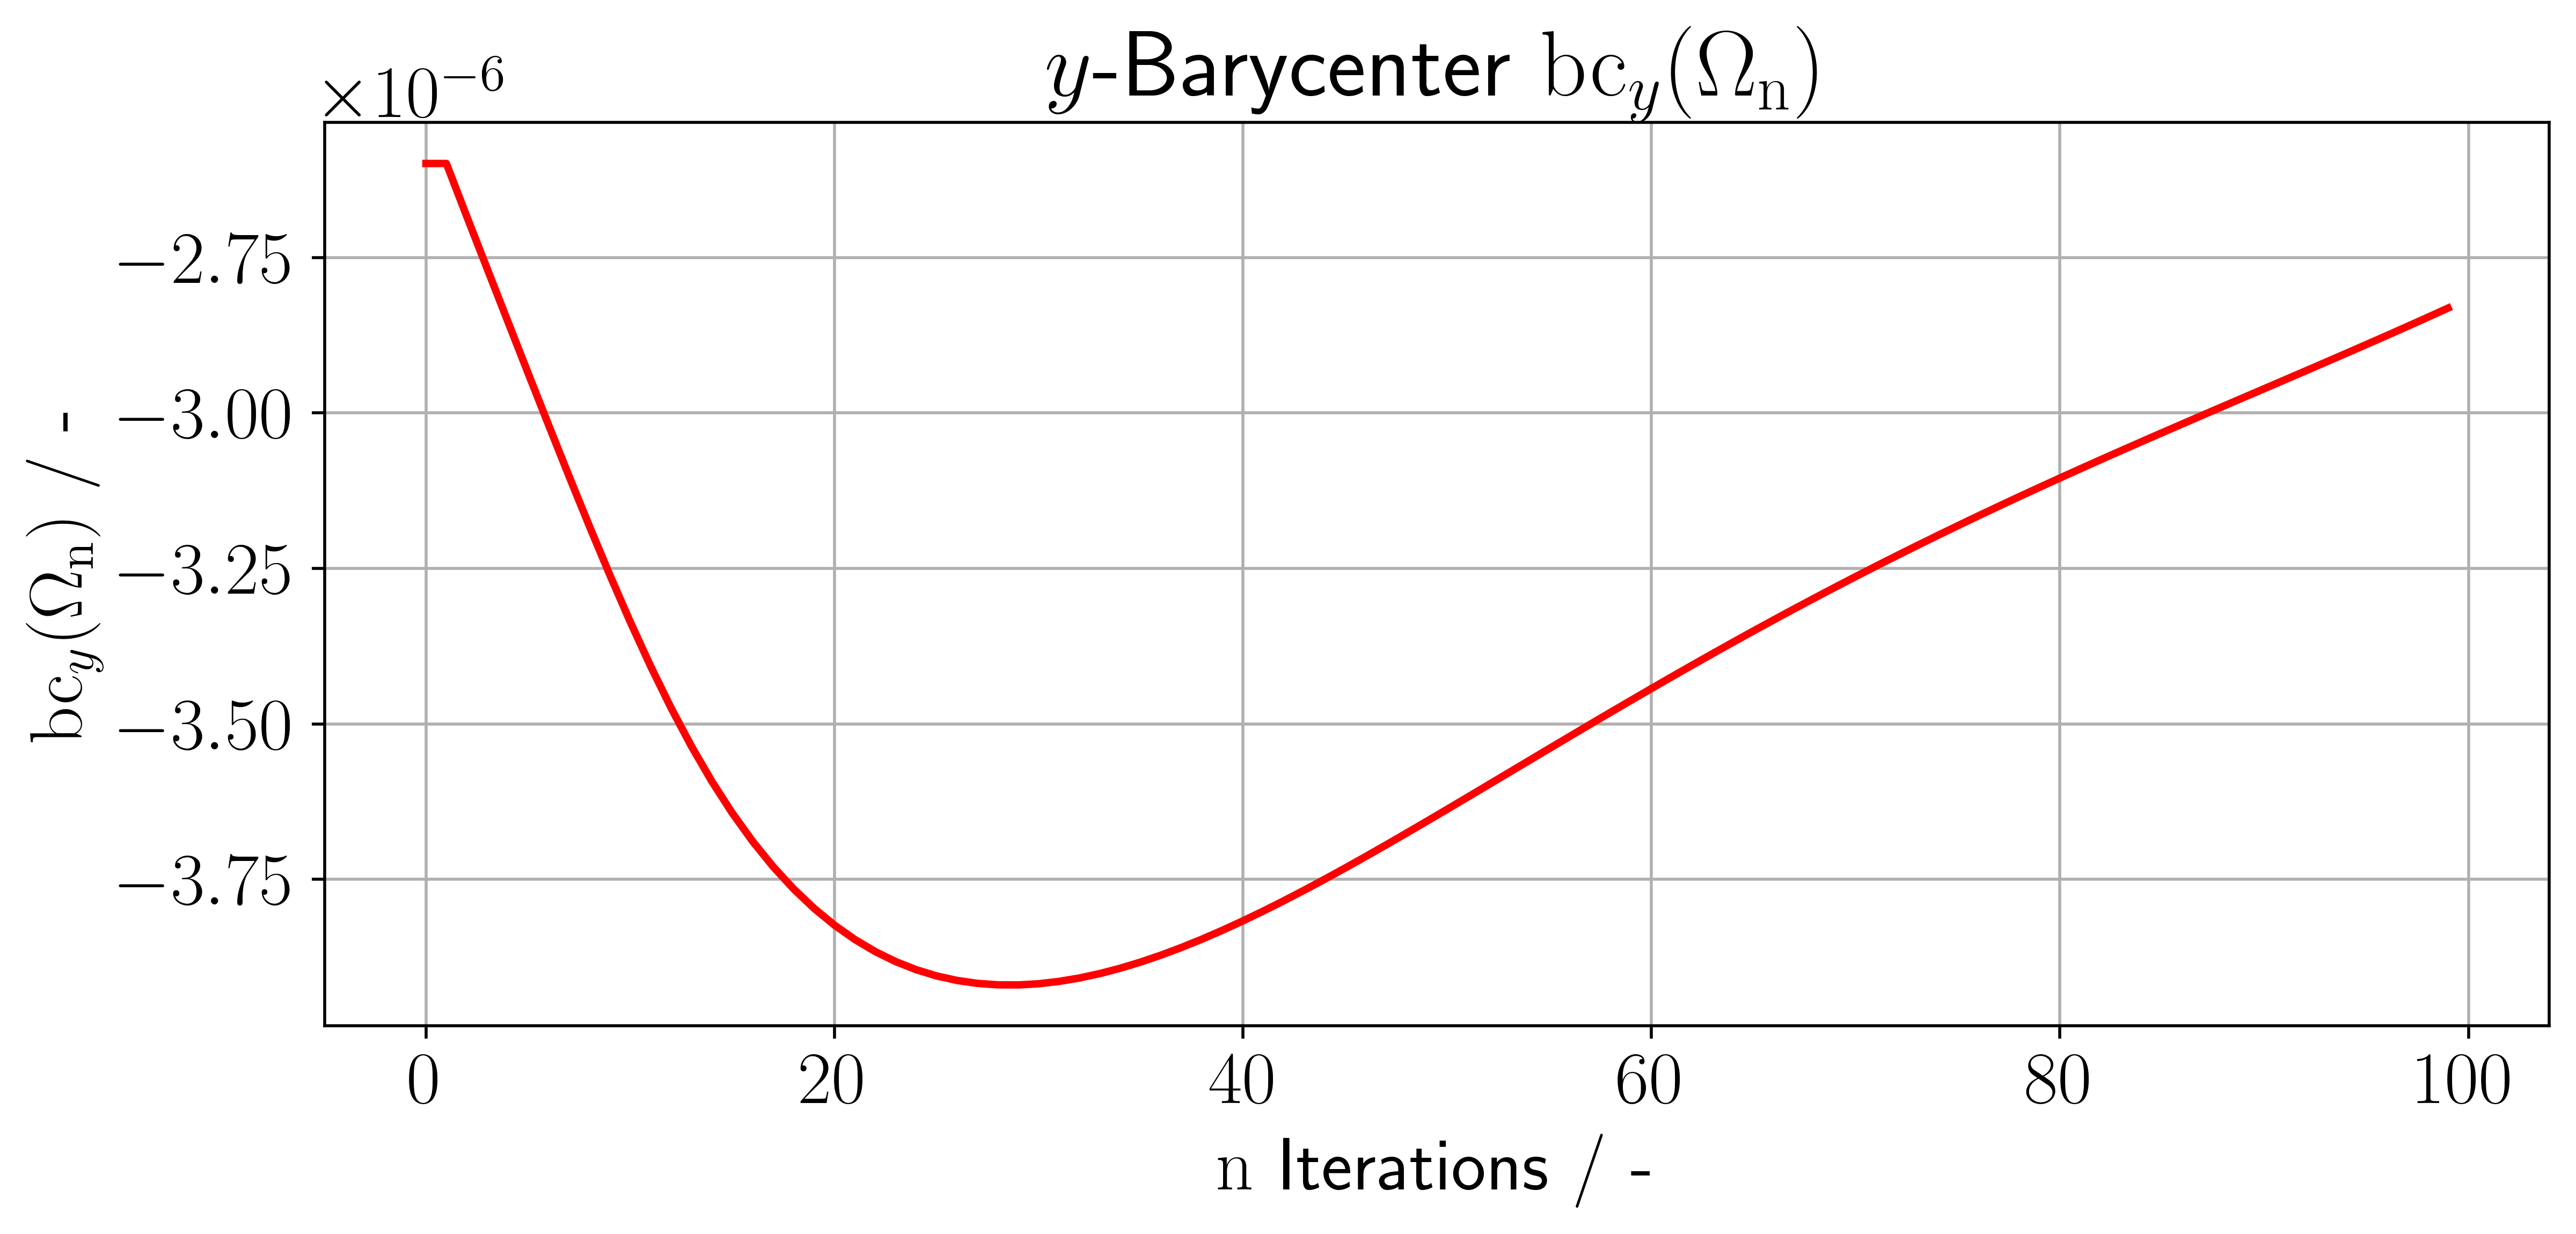

<Figure size 4000x1500 with 0 Axes>

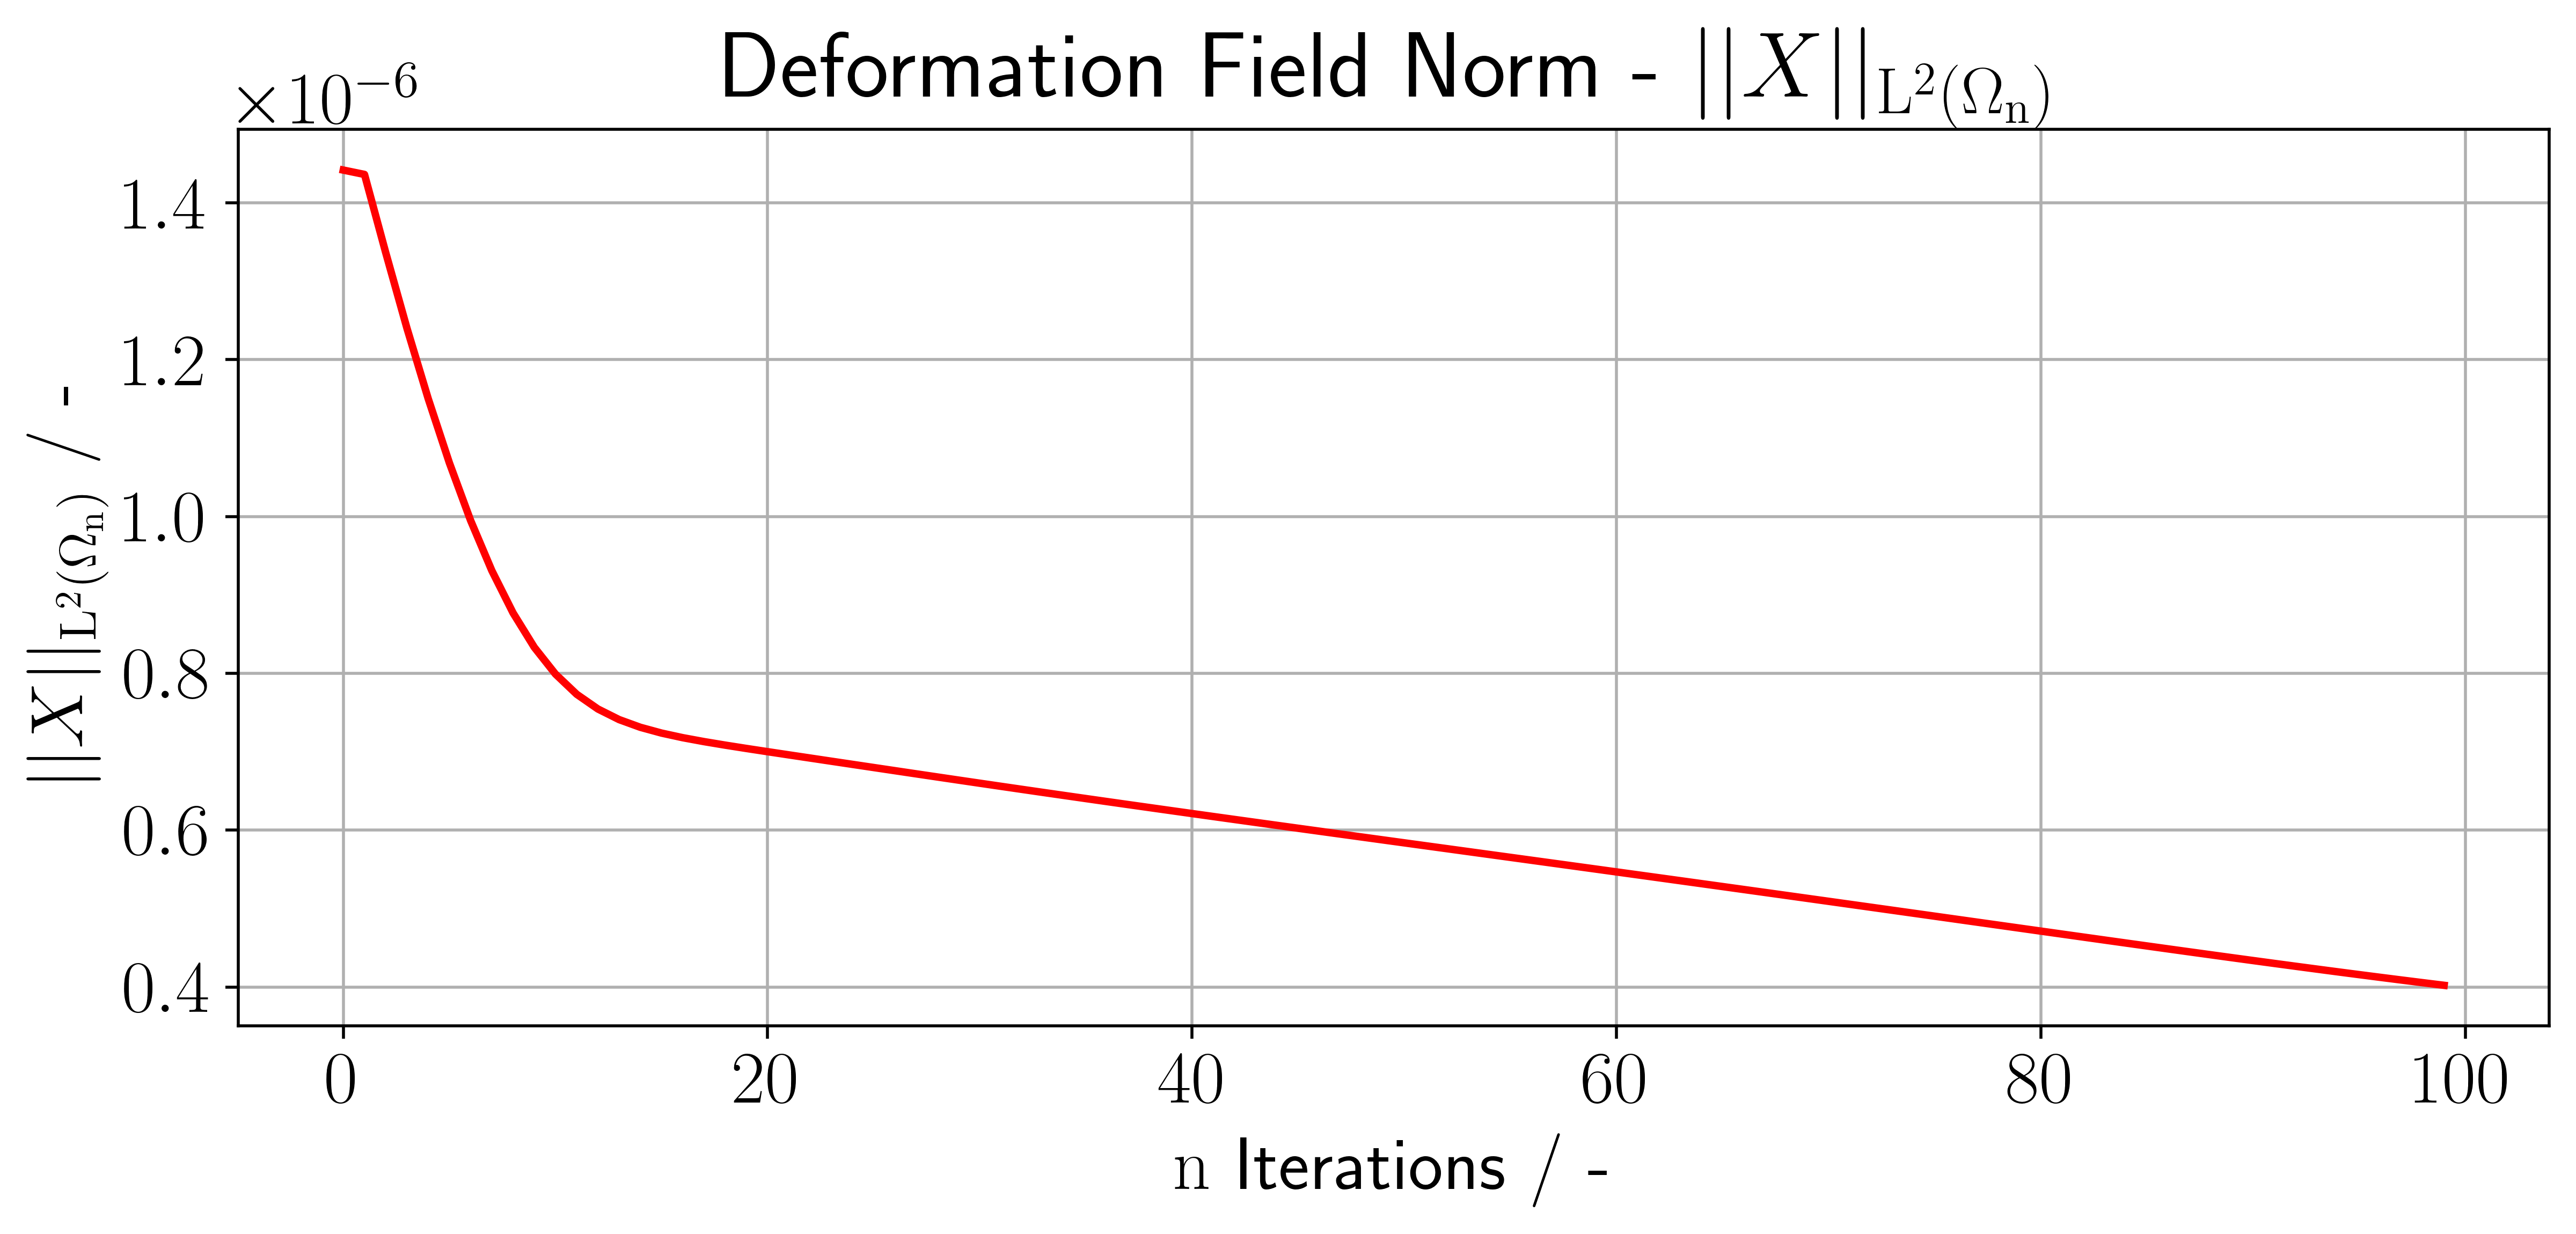

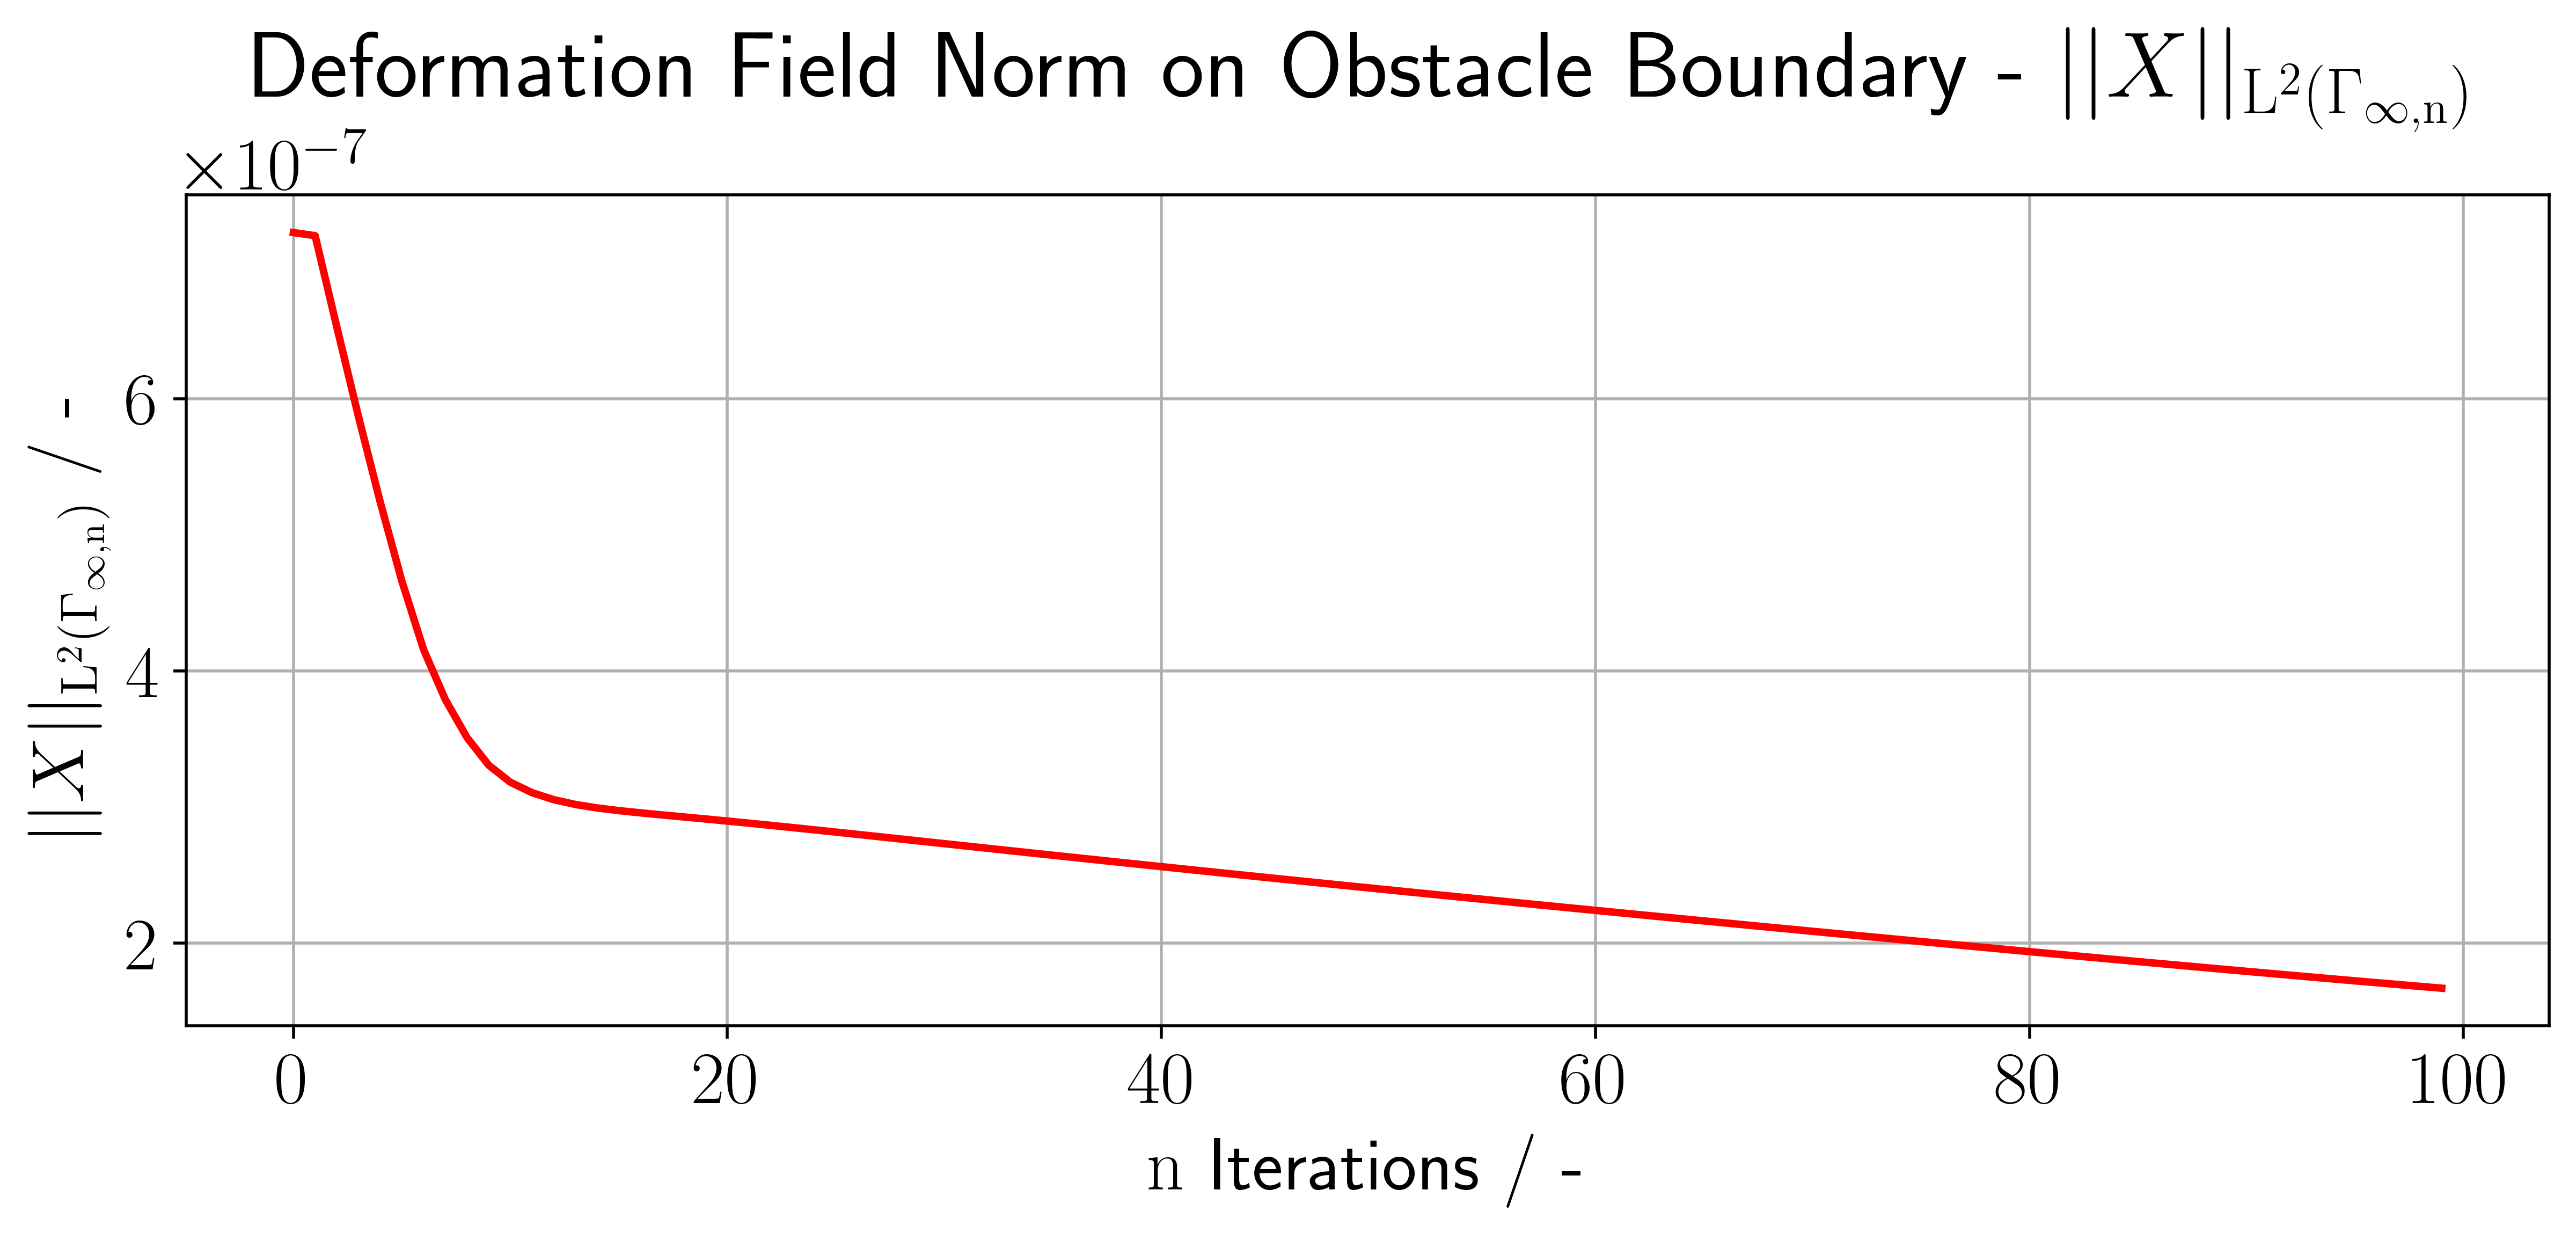

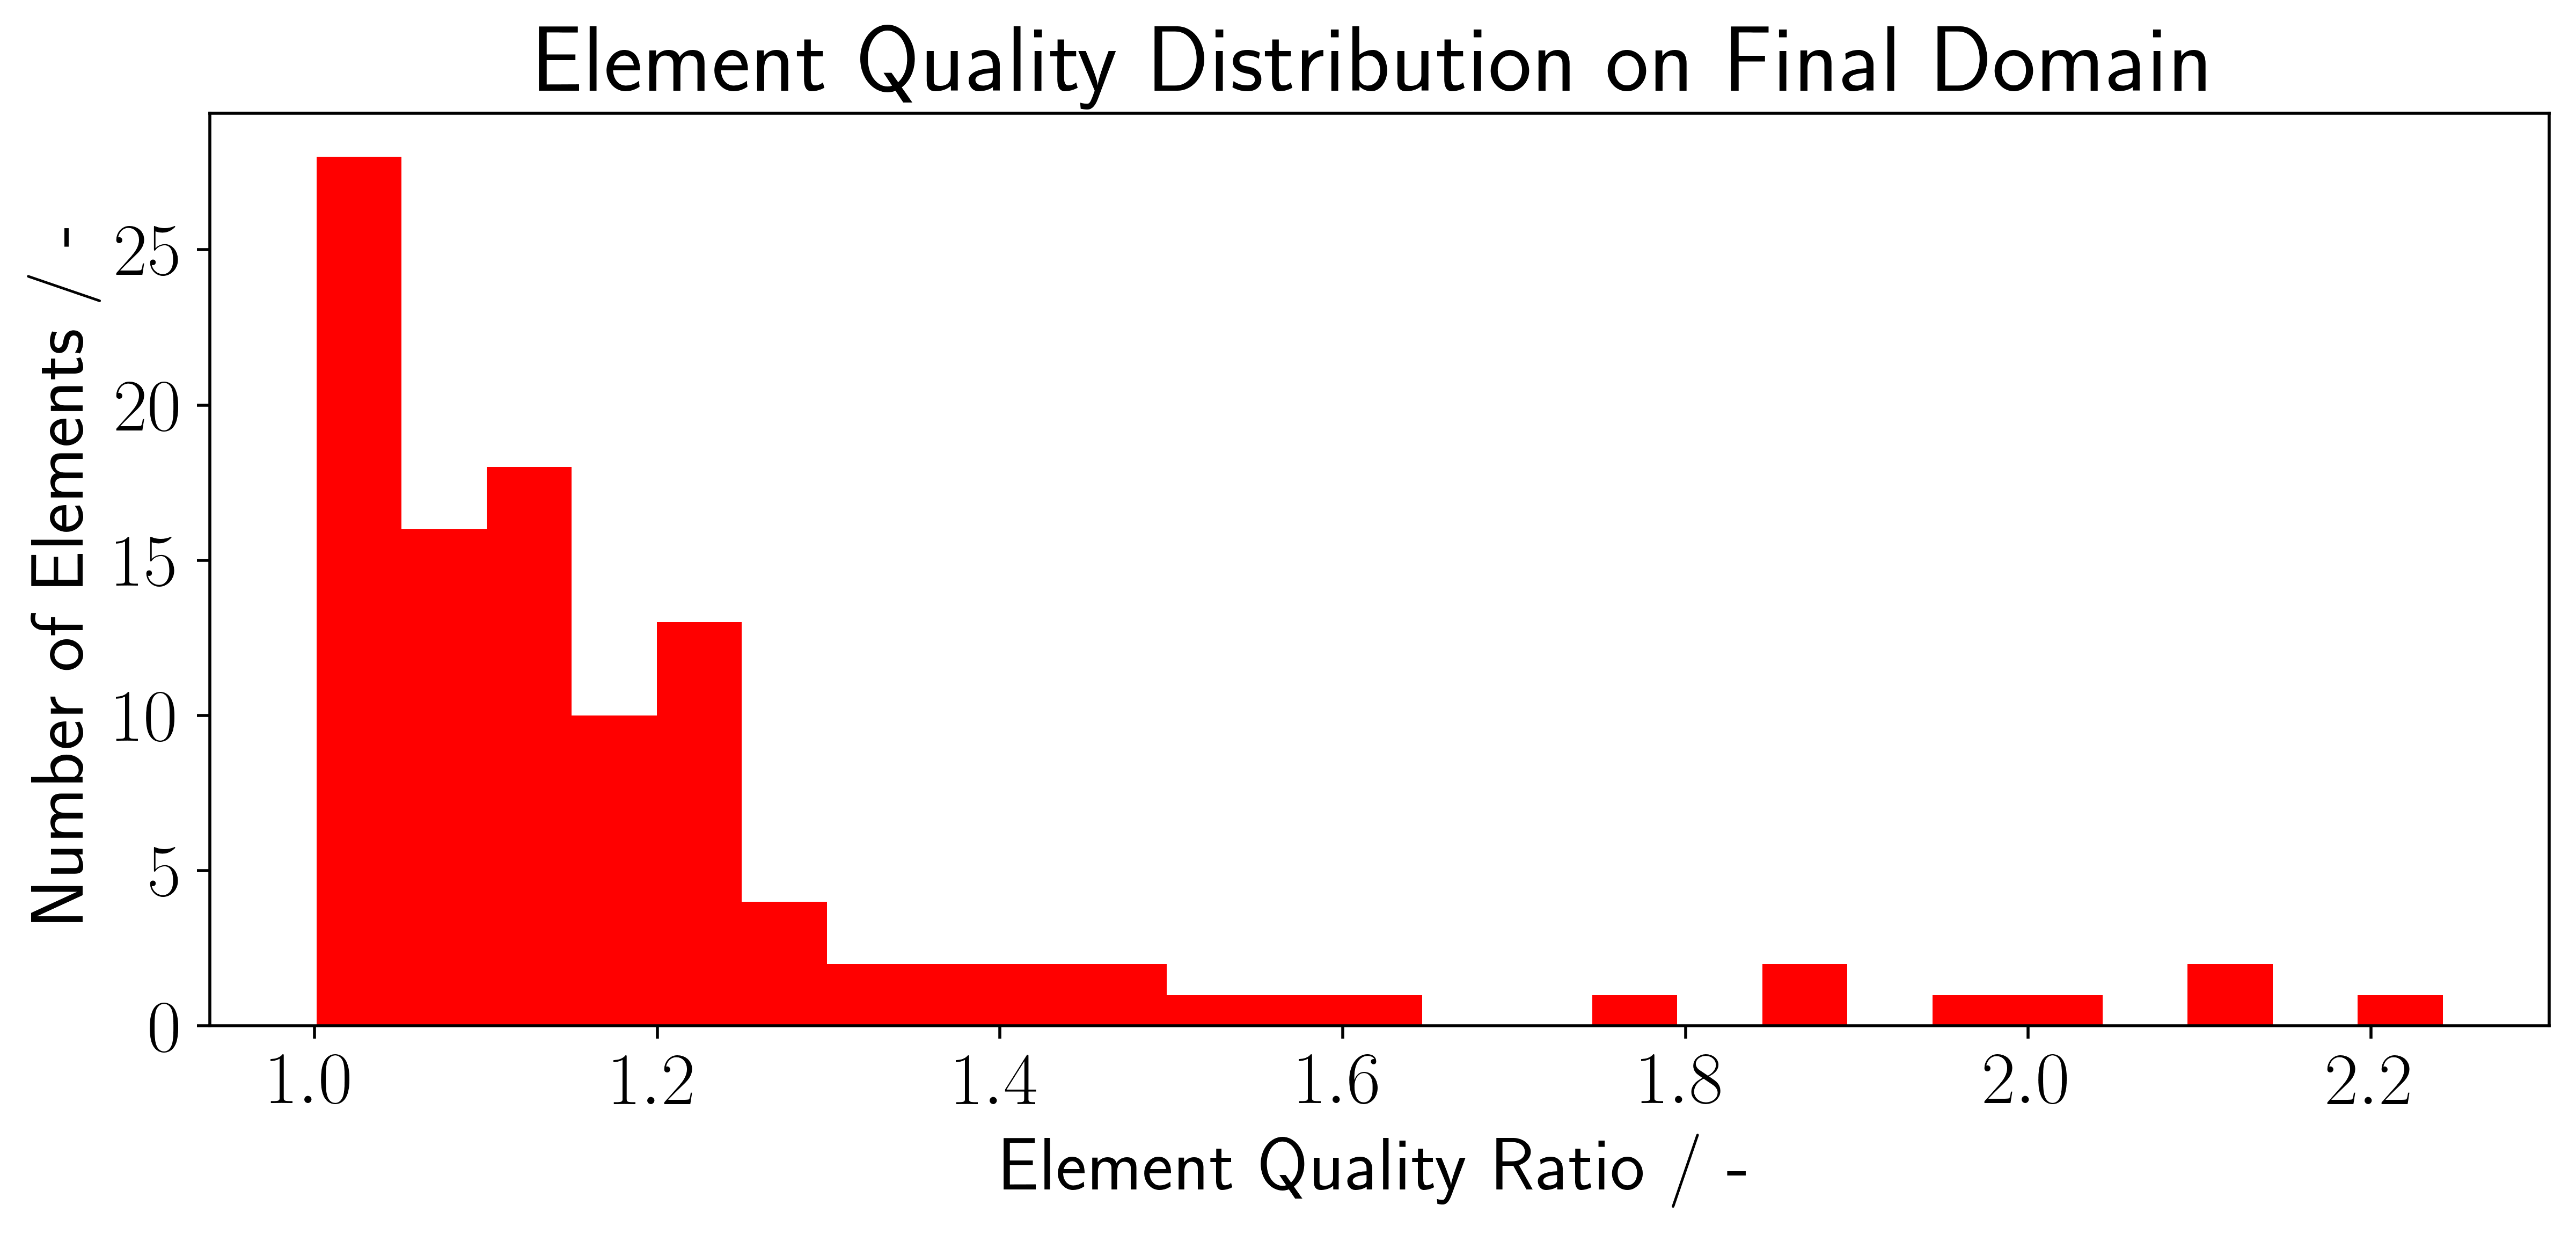

In [94]:
coding_on_camilos_laptop = True



fsx=10
fsy=5
plot_color = 'red'
plot_linewidth = 2
plt.rcParams['figure.dpi'] = 500  

# Energy Dissipation
plt.figure(0)
plt.figure(figsize=(fsx, fsy)) 
plt.title(' Energy Dissipation $J(\Omega_{\mathrm{n}})$')
plt.plot(data[0], color=plot_color, linewidth=plot_linewidth)
plt.xlabel('$\mathrm{n}$ Iterations / -')
plt.ylabel('$J(\Omega_{\mathrm{n}})$ / -')
plt.grid()
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/energy_diss_plot.pdf')

# Volume
plt.figure(1)
plt.figure(figsize=(fsx, fsy))
plt.title('Domain Volume $ \mathrm{vol}( \Omega_{\mathrm{n}} )$')
plt.plot(data[1], color=plot_color, linewidth=plot_linewidth)
plt.xlabel('$\mathrm{n}$ Iterations / -')
plt.ylabel('$\mathrm{vol}(\Omega_{\mathrm{n}})$ / -')
plt.grid() 
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/volume_plot.pdf')
 
# bc_x
plt.figure(2)
plt.figure(figsize=(fsx, fsy)) 
plt.title('$x$-Barycenter $ \mathrm{bc}_x(\Omega_{\mathrm{n}}) $')
plt.plot(data[2], color=plot_color, linewidth=plot_linewidth)
plt.ylabel('$ \mathrm{bc}_x(\Omega_{\mathrm{n}}) $ / -')
plt.grid()
plt.xlabel('$\mathrm{n}$ Iterations / -')
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/bc_x__plot.pdf')

# bc_y
plt.figure(3)
plt.figure(figsize=(fsx, fsy)) 
plt.title('$y$-Barycenter $ \mathrm{bc}_y(\Omega_{\mathrm{n}}) $')
plt.plot(data[3], color=plot_color, linewidth=plot_linewidth)
plt.xlabel('$\mathrm{n}$ Iterations / -')
plt.ylabel('$ \mathrm{bc}_y(\Omega_{\mathrm{n}}) $ / -')
plt.grid()
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/bc_y_plot.pdf')

# gfxnorm
plt.figure(5)
plt.figure(figsize=(fsx, fsy)) 
plt.title('Deformation Field Norm - $ || X ||_{\mathrm{L}^2(\Omega_{\mathrm{n}})} $')
plt.plot(data[5], color=plot_color, linewidth=plot_linewidth)
plt.ylabel('$ || X ||_{\mathrm{L}^2(\Omega_{\mathrm{n}})} $ / -')
plt.grid()
plt.xlabel('$\mathrm{n}$ Iterations / -')
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/gfxnorm_plot.pdf')

# gfx_bndnorm
plt.figure(6)
plt.figure(figsize=(fsx, fsy)) 
plt.title('Deformation Field Norm on Obstacle Boundary - $ || X ||_{\mathrm{L}^2(\Gamma_{\infty , \mathrm{n}})} $')
plt.plot(data[6], color=plot_color, linewidth=plot_linewidth)
plt.ylabel('$ || X ||_{\mathrm{L}^2(\Gamma_{\infty , \mathrm{n}})} $ / -')
plt.grid()
plt.xlabel('$\mathrm{n}$ Iterations / -')
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/gfx_bndnorm_plot.pdf')

plt.figure(7)

plt.figure(figsize=(fsx, fsy))
plt.title("Element Quality Distribution on Final Domain") 
plt.hist(Element_Quality_Data, 25, color=plot_color)
plt.ylabel("Number of Elements / -")
plt.grid()
plt.xlabel("Element Quality Ratio / -")
plt.tight_layout()
if(coding_on_camilos_laptop==True):
    plt.savefig('/home/tellocam/comp_math_SE/latex_telo/figures/element_quality_hist.pdf')


plt.grid()